# Tatoeba: N-Gram Hashing

Author: Pierre Nugues

In this notbook, we will reduce the size of the n-gram vectors using hashing techniques

This is a preliminary step to understand language detection and CLD3, https://github.com/google/cld3

In [2]:
import random
from collections import Counter
import torch
import matplotlib.pyplot as plt

In [3]:
random.seed(4321)
torch.manual_seed(4321)

## Reading the Dataset

In [4]:
FILE = 'sentences.csv'

Adjust your path

In [5]:
SMALL_DATASET_PATH = '.'
LARGE_DATASET_PATH = '.'

In [6]:
SMALL = False

In [7]:
if SMALL:
    dataset_path = SMALL_DATASET_PATH
else:
    dataset_path = LARGE_DATASET_PATH
    
WORKING_FILE = dataset_path + '/' + FILE

We create a generator

In [8]:
def file_reader(file):
    with open(file, encoding='utf8', errors='ignore') as f:
        for line in f:
            row = line.strip()
            yield tuple(row.split('\t'))

In [9]:
line_generator = file_reader(WORKING_FILE)

And we count the sentences per language

In [10]:
lang_freqs = Counter(map(lambda x: x[1], line_generator))

In [11]:
lang_freqs.most_common(15)

[('eng', 1919655),
 ('rus', 1083677),
 ('ita', 888171),
 ('epo', 766363),
 ('tur', 734304),
 ('kab', 722477),
 ('deu', 694683),
 ('ber', 676645),
 ('fra', 627564),
 ('por', 433886),
 ('hun', 411068),
 ('spa', 408395),
 ('jpn', 241802),
 ('heb', 201539),
 ('ukr', 186322)]

In [18]:
langs = sorted(list(set(lang_freqs.keys())))
langs[:10]

['\\N', 'abk', 'acm', 'ady', 'afb', 'afh', 'afr', 'aii', 'ain', 'ajp']

## Extracting n-grams

In [19]:
def ngrams(sentence, n=1, lc=True):
    ngram_l = []
    if lc:
        sentence = sentence.lower()
    for i in range(len(sentence) - n + 1):
        ngram_l += [sentence[i:i+n]]
    return ngram_l

In [20]:
def all_ngrams(sentence, max_ngram=3, lc=True):
    all_ngram_list = []
    for i in range(1, max_ngram + 1):
        all_ngram_list += [ngrams(sentence, n=i, lc=lc)]
    return all_ngram_list

In [21]:
all_ngrams('banana')

[['b', 'a', 'n', 'a', 'n', 'a'],
 ['ba', 'an', 'na', 'an', 'na'],
 ['ban', 'ana', 'nan', 'ana']]

## Extracting n-grams from the corpus

In [22]:
def extract_ngrams():
    with open(WORKING_FILE, encoding='utf8', errors='ignore') as f:
        for line in f:
            row = line.strip()
            lang_tuple = tuple(row.split('\t'))
            lang = lang_tuple[1]
            if lang in langs:
                yield all_ngrams(lang_tuple[2])       

We assume three, otherwise we have to create a list

In [23]:
charset = set()
bigram_set = set()
trigram_set = set()

In [24]:
for triple in extract_ngrams():
    charset.update(triple[0])
    bigram_set.update(triple[1])
    trigram_set.update(triple[2])


In [25]:
len(charset), len(bigram_set), len(trigram_set)

(10854, 361766, 1536870)

## Hashing the n-grams and limiting their numbers

In [26]:
hash('ads'), hash('ads') % 100

(-5048042572070127599, 1)

In [27]:
if SMALL:
    MAX_CHARS = 521
    MAX_BIGRAMS = 1031
    MAX_TRIGRAMS = 1031  
else:
    MAX_CHARS = 2053
    MAX_BIGRAMS = 4099
    MAX_TRIGRAMS = 4099  #8192

In [28]:
NUM_FEATURES = MAX_CHARS + MAX_BIGRAMS + MAX_TRIGRAMS
NUM_FEATURES

10251

In [29]:
def hash_conflicts(symbol_set, modulo):
    conflict_dict = dict()
    for symb in symbol_set:
        hash_code = hash(symb) % modulo
        if hash_code in conflict_dict:
            conflict_dict[hash_code] += [symb]
        else:
            conflict_dict[hash_code] = [symb]
    return conflict_dict

In [30]:
hash_conflicts_1 = hash_conflicts(charset, MAX_CHARS)
hash_conflicts_2 = hash_conflicts(bigram_set, MAX_BIGRAMS)
hash_conflicts_3 = hash_conflicts(trigram_set, MAX_TRIGRAMS)

In [50]:
hash('a') % 2053

1745

In [51]:
hash_conflicts_1[1745]

['ｙ', '쿠', '倹', 'ȋ', 'a', '买', '骨']

Expected number of symbols per hash code

In [31]:
len(charset)/MAX_CHARS, len(bigram_set)/MAX_BIGRAMS, len(trigram_set)/MAX_TRIGRAMS

(5.286897223575256, 88.25713588680166, 374.93778970480605)

Observed frequencies

In [32]:
cnt_hc_1 = Counter(map(len, hash_conflicts_1.values()))
cnt_hc_1

Counter({5: 377,
         4: 331,
         6: 322,
         3: 273,
         7: 217,
         8: 161,
         2: 134,
         9: 81,
         10: 48,
         1: 48,
         11: 19,
         12: 18,
         13: 6,
         14: 2,
         16: 1,
         15: 1})

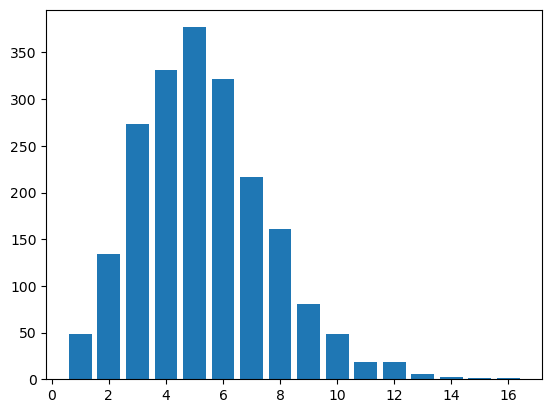

In [33]:
plt.bar(cnt_hc_1.keys(), cnt_hc_1.values())
plt.show()

In [34]:
cnt_hc_2= Counter(map(len, hash_conflicts_2.values()))
cnt_hc_2

Counter({87: 186,
         88: 184,
         90: 178,
         86: 164,
         85: 161,
         91: 157,
         84: 154,
         89: 154,
         93: 153,
         92: 152,
         83: 151,
         81: 141,
         94: 137,
         95: 135,
         80: 133,
         82: 130,
         96: 116,
         97: 112,
         79: 111,
         78: 103,
         98: 100,
         77: 88,
         99: 86,
         100: 82,
         76: 75,
         102: 63,
         75: 60,
         101: 59,
         74: 54,
         103: 51,
         104: 50,
         71: 40,
         72: 36,
         105: 32,
         73: 32,
         70: 31,
         106: 28,
         68: 25,
         107: 25,
         109: 21,
         69: 20,
         108: 20,
         65: 15,
         66: 15,
         112: 12,
         111: 10,
         110: 9,
         67: 8,
         113: 8,
         116: 4,
         64: 4,
         114: 3,
         63: 3,
         117: 2,
         119: 2,
         123: 2,
         115: 2,
 

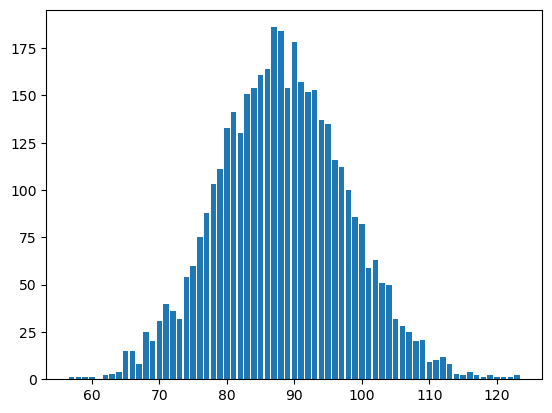

In [35]:
plt.bar(cnt_hc_2.keys(), cnt_hc_2.values())
plt.show()

In [36]:
cnt_hc_3 = Counter(map(len, hash_conflicts_3.values()))

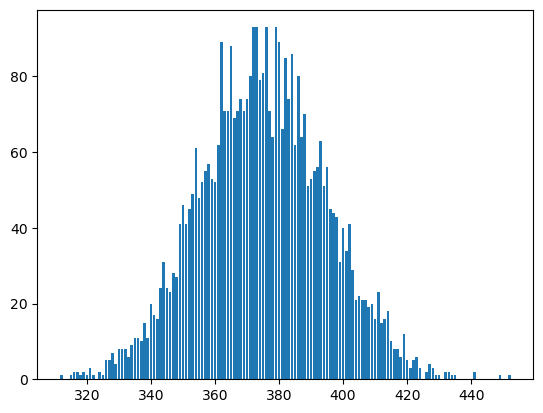

In [37]:
plt.bar(cnt_hc_3.keys(), cnt_hc_3.values())
plt.show()